# <center>Characterization of pilot-based distributed executions on the<br>XSEDE OSG Virtual Cluster</center>

## Abstract

## Introduction

XSEDE offers diverse types of resources to support diverse types of computing: high performance, data intense, cloud, and grid. Users can execute their domain-specific applications on any of these resources, depending on application requirements. A growing number of scientific applications executes workflows that can benefit from different computing capabilities, depending on whether their execution requires single and multiple cores; small and large amount of data; or communication and coordination before, during and after runtime. The efficiency of the execution of these workflows can be improved by performing it concurrently and across multiple machines, possibly supporting diverse computing models. This is particularly relevant when considering workflows like those used to simulate and analyze the dynamic properties of molecular interactions (MD workflows)\mtnote{Make this more general}. These workflows have multiple stages, possibly organized in concurrent pipelines, may use asynchronous communication and coordination, while requiring both multi and single-core executions.

MD workflows are routinely executed on single, multi-core machines and technologies like pilot systems enables their efficient execution on diverse types of machines. Nonetheless, there is initial evidence~\cite{} that the concurrent distribution of the stages of these workflows on multiple machines could improve their time to completion (TTC). A further opportunity may lay in distributing the concurrent execution of these workflows across different types of machines, exploiting their different heterogeneity, dynamism, capacity, and availability. While this distributed and concurrent approach to execution of MD workflows may seem analytically promising, an empirical characterization of this execution on a specific type of resource is needed to produce qualitative and quantitative evidence. This characterization has to provide the boundary conditions for the distributed execution, describing its behavior under different applications requirements and resources' behavior.

In this paper, we characterize the distributed and concurrent execution of a representative component of a real-life MD workflow on the XSEDE OSG Virtual Cluster (XOVC). We characterize two types of resource dynamism, and n types of resource heterogeneity. XOVC exposes an OSG Connect broker~\cite{} for a dynamic pool of OSG resources. The pool is dynamic because it can shrink and expand depending on the load of the broker, and because the availability of pool's resources is not guaranteed over time. Resources can be available or unavailable depending on resource-defined policies, load, or fault. Further, the pool is assumed to have resources with heterogeneous architectures, geographical locations, and software environment. The XOVC resource pool can: (i) have different CPU, memory, storage or networking architectures; (ii) have single or clustered components; (iii) be grouped into a lab, data center or dislocated across campus locations; (iv) offer direct access to the operating system, use queues of a batch system, or mono- and multi-tenant resource containers and overlays.

The execution model of applications on XOVC is assumed to take into account both resource dynamisms and heterogeneities. This is supported with both policies and software tools: applications are assumed not to require more than one core per task and it is suggested to limit the runtime of each task to twelve hours~\cite{}. Task execution can be suspended or terminated at any time so task checkpointing or, more commonly~\cite{}, rescheduling is assumed to avoid failure. More in general, a certain amount of execution failure is not excluded, due to unassured resource availability but also incompatible execution environment. It should be noted that the heterogeneity of software stack on the pool resources implies non uniform availability of compilers, library, or executables. Applications are often assumed to take care of setting up a suitable execution environment.

We focus on use cases that may benefit from distributed and concurrent execution across diverse types of resources. We use a pilot-enabled, interoperable and integrated middleware, supporting a uniform execution model not only on the OSG resources made available by XSEDE but also on its HPC and cloud resources. Thanks to this middleware, pilots can be instantiated, for example, on XOVC, Stampede, Maverick and Bridges and the tasks of a given workflow can be concurrently executed across all the pilots as soon as they become available. The middleware alongside the its benefits and trade offs are described in Ref~\cite{}. Here we note that tasks can be executed sequentially on each pilot as long as that pilot is available and that multiple pilots can be used for concurrent executions. We can submit multiple jobs to XVOC and, once active, each job can bootstrap a pilot agent on which our application can concurrently schedule as many tasks for execution as cores are available to each agent. On OSG, each pilot has one core, so we execute as many tasks as pilots are available.

For our analysis we emulated the concurrent execution of a set of tasks. We call this set a workload and we consider it part of a larger workflow. Each task emulates the execution of AMBER,  a software package that simulates force fields for the dynamics of biomolecules. The parameters of our emulation are measured by profiling the execution of a real-life AMBER simulation, as peformed by \mtnote{name of the group} to simulate \mtnote{name of the protein and of the transformation}. \ldots~\mtnote{summary of contributions.}

This paper has five sections:\ldots~\mtnote{Brief summary of the sections of the paper.}

## Related Work

## Tools and Methods

* AIMES integrated middleware
* RADICAL-Pilot
* Synapse

We developed RADICAL-Pilot by defining an explicit event and state model. Events can be defined for each software component and states are events guaranteed to be ordered on a sequence. An exception is thrown if two states are not in the predefined order, halting the RADICAL-Pilot execution. Thanks to this approach, we were able to isolate and measure the overhead imposed on our 

## Experiments Design

We designed nine experiments, executing between 8 and 2048 emulations of an AMBER MD simulation. We emulate the simulation used in a real-life use case

| Experiment | <center>#CU</center>             | #Pilots | <center>Resource</center> |
|:----------:|---------------------------------:|---------|---------------------------|
| 01         | 8,16,32,64,128,256,512,1024,2048 | 8       | XSEDE OSG Virtual Cluster |
| 02         |   16,32,64,128,256,512,1024,2048 | 16      | XSEDE OSG Virtual Cluster |
| 03         |      32,64,128,256,512,1024,2048 | 32      | XSEDE OSG Virtual Cluster |
| 04         |         64,128,256,512,1024,2048 | 64      | XSEDE OSG Virtual Cluster |
| 05         |            128,256,512,1024,2048 | 128     | XSEDE OSG Virtual Cluster |
| 06         |                256,512,1024,2048 | 256     | XSEDE OSG Virtual Cluster |
| 07         |                    512,1024,2048 | 512     | XSEDE OSG Virtual Cluster |
| 08         |                        1024,2048 | 1024    | XSEDE OSG Virtual Cluster |
| 09         |                             2048 | 2048    | XSEDE OSG Virtual Cluster |

## Results and Discussion

In [28]:
%matplotlib inline

import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [29]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

Load wrangled data saved in .csv files.

In [30]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

Derive number of units requested and number of units rescheduled due to pilot halted/migrated by condor

In [31]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

In [32]:
display(units['U_AGENT_EXECUTING'].dropna().shape)
display(sessions['nunit_done'].sum())
pd.concat(
    [units.loc[units['U_AGENT_EXECUTING'].notnull()].groupby('sid').count()[['U_AGENT_EXECUTING']],
     sessions.loc[sessions['nunit_done'].isnull()]['nunit_done']], axis=1, join='inner')

(66420,)

66533

,U_AGENT_EXECUTING,nunit_done


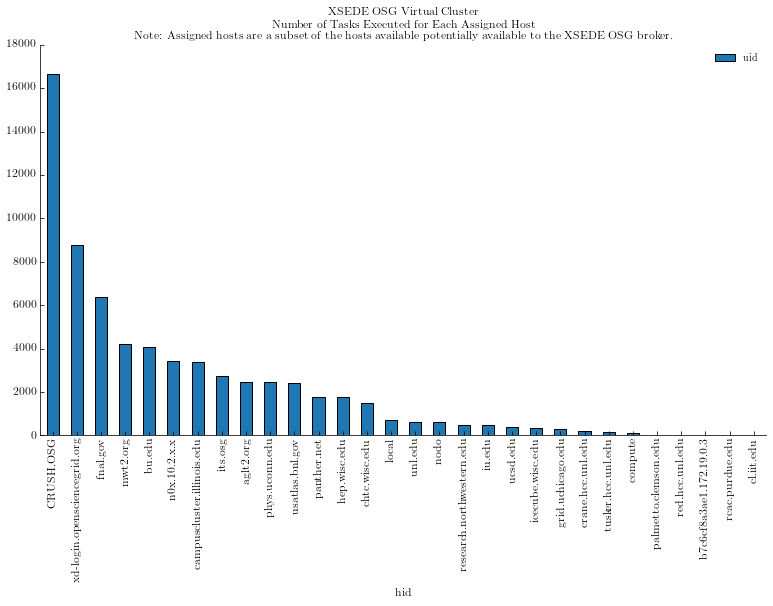

In [33]:
# TODO: Number of successful Task executions per host (x = hosts; y = number of executed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].notnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

,uid
hid,
n0x.10.2.x.x,9744
xd-login.opensciencegrid.org,2835
CRUSH.OSG,1430
phys.uconn.edu,193
tusker.hcc.unl.edu,96
bu.edu,58
panther.net,15
mwt2.org,14
chtc.wisc.edu,11


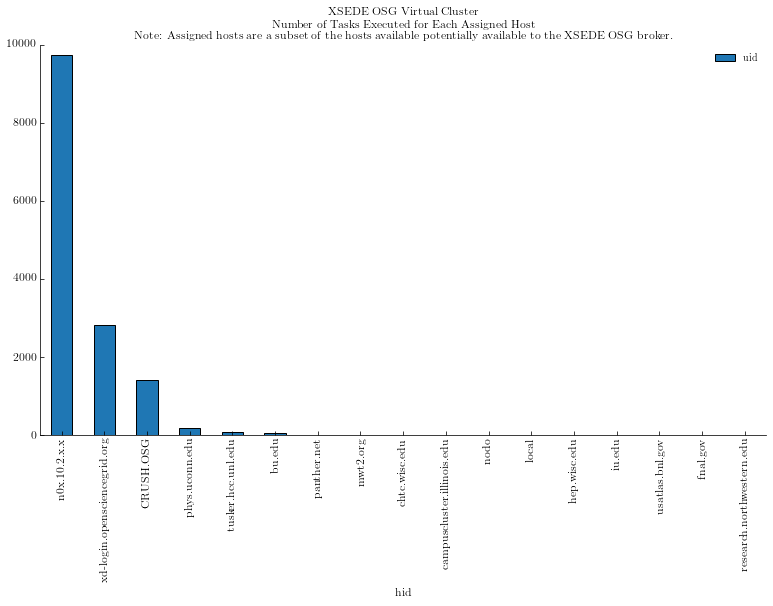

In [34]:
# TODO: Number of failed Task executions per host (x = hosts; y = number of failed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].isnull()]
display(us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False))
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

In [35]:
# TODO: Number of requsted pilots Vs number of active pilots (x = sessions; y = integers)

In [36]:
# TODO: Number of unit rescheduled Vs TTC (x = TTC; y = number of units rescheduled)

KeyError: 'exp10'

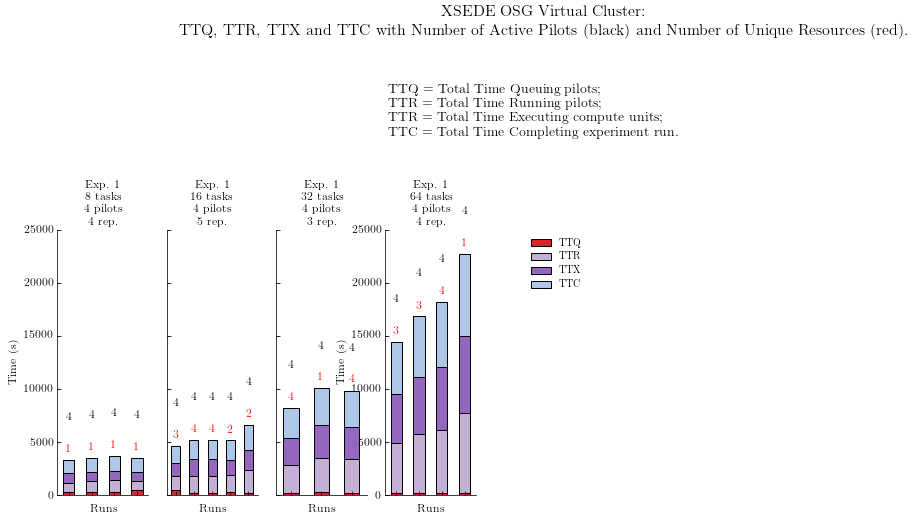

In [37]:
fig = plt.figure(figsize=(18,20))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttx': 'TTR = Total Time Executing compute units',
        'ttc': 'TTC = Total Time Completing experiment run'}
defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

gs = []
grid  = gridspec.GridSpec(3, 2)
grid.update(wspace=0.4, hspace=0.4, top=0.825)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=grid[4]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[5]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunit_requested'].sort_values().unique():
        if not sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun)].empty:
            ttq_subplots.append(sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp2': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp3': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp4': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp5': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp6': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]]}


nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp5']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp6']['nunit_requested'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(6):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunit'].unique()[0])
            npilots = int(session[session['experiment'] == experiment]['npilot'][0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['P_LRMS_QUEUING', 
                     'P_LRMS_RUNNING',
                     'U_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16 or i == 28:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 23:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(3.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels.
            rects = ax[i].patches
            label_np = [int(l) for l in session['npilot_active']]
            label_nh = [int(l) for l in session['nhost']]
            nh = [r.get_height() for r in rects]
            n = len(nh)/4              # Number of groups of 4 stacked bars
            # partition the list of heights nh into number of bars n partitions;
            # zip partitions into tuples t of n stacked bars;
            # sum eacth tuple into the hight of n stacked bars.
            heights = [sum(t) for t in zip(*[nh[j:j + n] for j in xrange(0, len(nh), n)])]
            
            # Add labels with number of pilots requested per session.
            for rect, label, height in zip(rects[-repetitions:], label_np, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+3500, label, ha='center', va='bottom')
            
            # Add labels with number of unique resources per session.
            for rect, label, height in zip(rects[-repetitions:], label_nh, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+500, label, ha='center', va='bottom', color='red')

            fig.add_subplot(ax[i])
            i += 1
            
plt.savefig('figures/osg_experiment_comparison.pdf', dpi=600, bbox_inches='tight')

# Analysis Total Unit Execution Time ($TTX$)

# Analysis Total Pilot Queuing Time ($TTQ$)

# Analysis Unit Execution Time ($T_x$)

In [38]:
units['U_AGENT_EXECUTING'].dropna().describe()

count    66420.000000
mean       448.601265
std        323.561391
min        120.365900
25%        259.743800
50%        356.353400
75%        508.505100
max       5545.682500
Name: U_AGENT_EXECUTING, dtype: float64

## Distribution of $T_x$

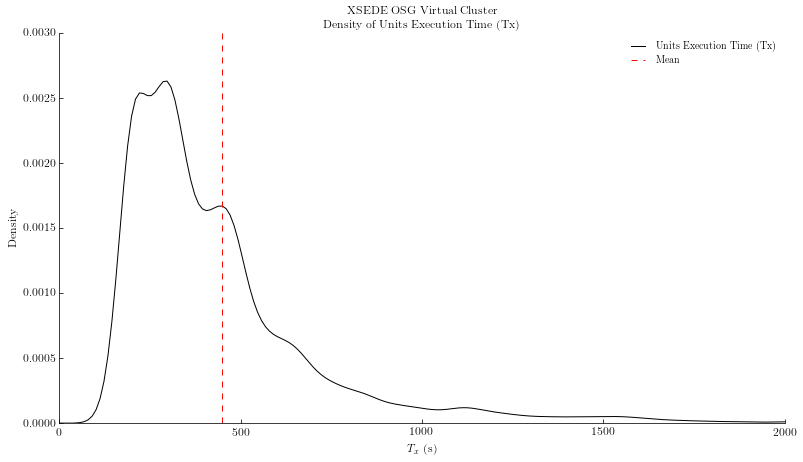

In [39]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)'

tx_all  = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'all': tx_all}) 

utxs.plot.density(ax=ax, color='black', title=title)
#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

utxs.to_csv()
plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

## Comparison of the Distribution of $T_x$ per Experiment

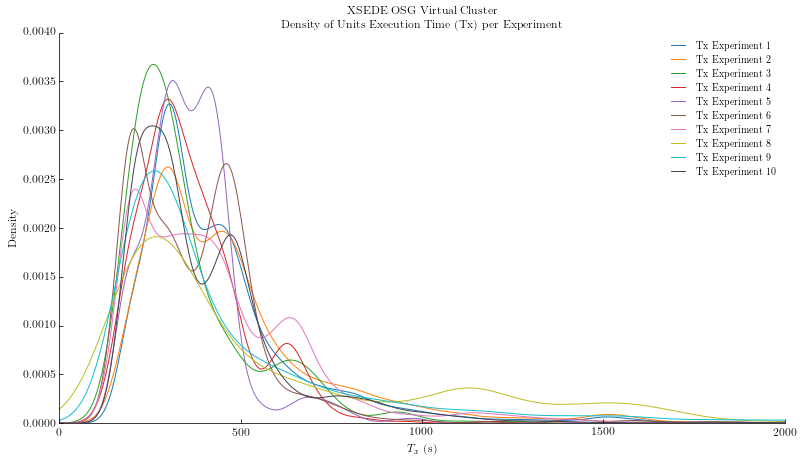

In [40]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment'

tx_exp1  = units[units['experiment'].str.contains('exp1' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp2  = units[units['experiment'].str.contains('exp2' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp3  = units[units['experiment'].str.contains('exp3' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4  = units[units['experiment'].str.contains('exp4' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp5  = units[units['experiment'].str.contains('exp5' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp6  = units[units['experiment'].str.contains('exp6' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp7  = units[units['experiment'].str.contains('exp7' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp8  = units[units['experiment'].str.contains('exp8' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp9  = units[units['experiment'].str.contains('exp9' )]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp10 = units[units['experiment'].str.contains('exp10')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp11 = units[units['experiment'].str.contains('exp11')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'exp1': tx_exp1  , 'exp2': tx_exp2  , 'exp3': tx_exp3, 
                     'exp4': tx_exp4  , 'exp5': tx_exp5  , 'exp6': tx_exp6, 
                     'exp7': tx_exp7  , 'exp8': tx_exp8  , 'exp9': tx_exp9,
                     'exp10': tx_exp10, 'exp10': tx_exp11,})

utxs.plot.density(ax=ax, color=[tableau20[0 ],tableau20[2 ],tableau20[4 ],
                                tableau20[6 ],tableau20[8 ],tableau20[10],
                                tableau20[12],tableau20[14],tableau20[16],
                                tableau20[18],tableau20[20]], title=title)

ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Tx Experiment 1' , 'Tx Experiment 2' , 'Tx Experiment 3', 
                  'Tx Experiment 4' , 'Tx Experiment 5' , 'Tx Experiment 6',
                  'Tx Experiment 7' , 'Tx Experiment 8' , 'Tx Experiment 9',
                  'Tx Experiment 10', 'Tx Experiment 11'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

## Comparison of the Distribution of Six Shuffled Partitions of the Set of Units

In [41]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp7 = units[units['experiment'].str.contains('exp7')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp8 = units[units['experiment'].str.contains('exp8')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp9 = units[units['experiment'].str.contains('exp9')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

txd_all = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()
txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)

# Partions with 1/4 elements of the total set of units.
txd_shf1 = txd_shuffled[:6107].describe() 
txd_shf2 = txd_shuffled[6108:12215].describe()
txd_shf3 = txd_shuffled[12216:18323].describe()
txd_shf4 = txd_shuffled[18324:24431].describe()
txd_shf5 = txd_shuffled[24432:30540].describe()
txd_shf6 = txd_shuffled[30541:36648].describe()
txd_shf7 = txd_shuffled[36649:42756].describe()
txd_shf8 = txd_shuffled[42757:48864].describe()
txd_shf9 = txd_shuffled[48865:].describe()

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1,'exp2': txd_exp2,'exp3': txd_exp3,'exp4': txd_exp4,
                                    'exp5': txd_exp5,'exp6': txd_exp6,'exp7': txd_exp7,'exp8': txd_exp8,
                                    'exp9': txd_exp9,
                                    'shf1': txd_shf1,'shf2': txd_shf2,'shf3': txd_shf3,'shf4': txd_shf4,
                                    'shf5': txd_shf5,'shf6': txd_shf6,'shf7': txd_shf7,'shf8': txd_shf8,
                                    'shf9': txd_shf9})

tx_exp_descriptions

,all,exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8,exp9,shf1,shf2,shf3,shf4,shf5,shf6,shf7,shf8,shf9
count,66420.000000,11919.000000,416.000000,544.000000,992.000000,4056.000000,15706.000000,5657.000000,11154.000000,15976.000000,6107.000000,6107.000000,6107.000000,6107.000000,6108.000000,6107.000000,6107.000000,6107.000000,17555.000000
mean,448.601265,442.112545,355.228207,366.691442,363.009487,381.689740,440.323678,581.454594,488.221381,414.398403,449.064678,459.229571,444.585481,450.916958,450.692258,443.043405,450.922639,443.741012,447.432074
std,323.561391,236.878052,174.757958,145.174483,134.266899,207.245654,265.823951,514.864512,441.845775,263.820209,317.872210,343.833010,306.512724,330.055251,338.371716,309.508687,341.510887,306.423827,320.619476
min,120.365900,160.391100,185.204400,136.134200,170.191000,133.432300,120.365900,134.133300,128.124900,159.096200,126.717800,127.591100,126.265400,127.051500,125.473300,120.365900,130.363800,129.556200,127.937900
25%,259.743800,296.523050,237.678925,275.037775,282.287225,207.928125,253.522650,246.511800,239.245150,251.687600,261.385500,257.245050,260.255300,258.501600,261.258525,259.587950,258.122250,257.288050,261.242150
50%,356.353400,381.957300,299.423700,332.309950,345.135050,352.329750,384.393900,360.379800,327.334450,331.262650,359.395700,358.368200,353.630300,355.648600,357.575450,353.360800,351.361500,354.683000,356.707200
75%,508.505100,504.433250,415.966475,442.318075,424.428400,473.357225,559.558900,766.763000,552.172275,483.752400,513.286850,520.573700,503.494100,515.357250,506.667475,509.510600,501.499500,504.579100,506.196950
max,5545.682500,2383.290400,1258.610500,1189.620700,1382.527900,2216.327500,4135.194400,5545.682500,4880.923500,3791.195500,4406.605300,4880.923500,3785.789700,5410.618500,5545.682500,5442.668400,5309.456100,4354.849100,5079.101700


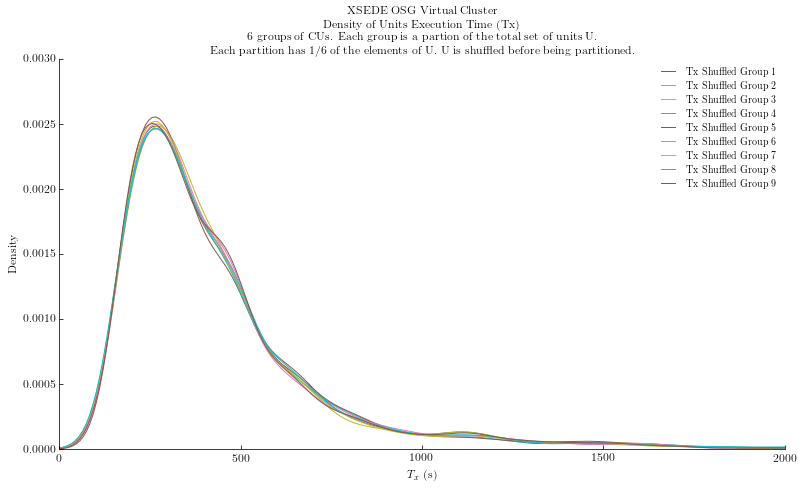

In [15]:
fig, ax = fig_setup()
resource = 'XSEDE OSG Virtual Cluster'
description = 'Density of Units Execution Time (Tx)'
explanation1 = '6 groups of CUs. Each group is a partion of the total set of units U'
explanation2 = 'Each partition has 1/6 of the elements of U. U is shuffled before being partitioned'
title='%s\n%s\n%s.\n%s.' % (resource, description, explanation1, explanation2)

txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)
txd_shf1 = txd_shuffled[:6107].reset_index(drop=True).tolist()
txd_shf2 = txd_shuffled[6108:12215].reset_index(drop=True).tolist()
txd_shf3 = txd_shuffled[12216:18323].reset_index(drop=True).tolist()
txd_shf4 = txd_shuffled[18324:24431].reset_index(drop=True).tolist()
txd_shf5 = txd_shuffled[24432:30540].reset_index(drop=True).tolist()
txd_shf6 = txd_shuffled[30541:36648].reset_index(drop=True).tolist()
txd_shf7 = txd_shuffled[36649:42756].reset_index(drop=True).tolist()
txd_shf8 = txd_shuffled[42757:48864].reset_index(drop=True).tolist()
txd_shf9 = txd_shuffled[48865:].reset_index(drop=True).tolist()

df_shf1 = pd.DataFrame(txd_shf1, columns=['shf1'])
df_shf2 = pd.DataFrame(txd_shf2, columns=['shf2'])
df_shf3 = pd.DataFrame(txd_shf3, columns=['shf3'])
df_shf4 = pd.DataFrame(txd_shf4, columns=['shf4'])
df_shf5 = pd.DataFrame(txd_shf5, columns=['shf6'])
df_shf6 = pd.DataFrame(txd_shf6, columns=['shf6'])
df_shf7 = pd.DataFrame(txd_shf7, columns=['shf7'])
df_shf8 = pd.DataFrame(txd_shf8, columns=['shf8'])
df_shf9 = pd.DataFrame(txd_shf9, columns=['shf9'])

# txd_shfs = pd.concat([df_exp1, df_exp2, df_exp3, df_exp4, 
#                       df_shf1, df_shf2, df_shf3, df_shf4], join='outer', axis=1)
txd_shfs = pd.concat([df_shf1, df_shf2, df_shf3, 
                      df_shf4, df_shf5, df_shf6,
                      df_shf7, df_shf8, df_shf9,], join='outer', axis=1)

# txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[0], tableau20[2], tableau20[8], tableau20[4],
#                                                  tableau20[10],tableau20[12],tableau20[14],tableau20[16]])
txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[10],tableau20[12],tableau20[14],tableau20[16]])

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')

ax.legend(labels=['Tx Shuffled Group 1','Tx Shuffled Group 2',
                  'Tx Shuffled Group 3','Tx Shuffled Group 4',
                  'Tx Shuffled Group 5','Tx Shuffled Group 6',
                  'Tx Shuffled Group 7','Tx Shuffled Group 8',
                  'Tx Shuffled Group 9'])

plt.savefig('figures/osg_tx_shuffled_frequency.pdf', dpi=600, bbox_inches='tight')

# $T_x$ as Function of Resource Heterogeneity

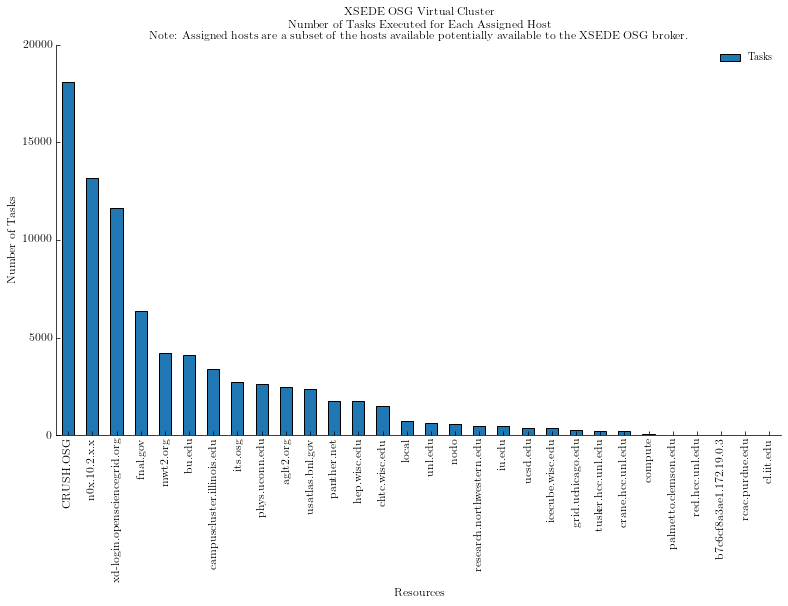

In [42]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Tasks'])

plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

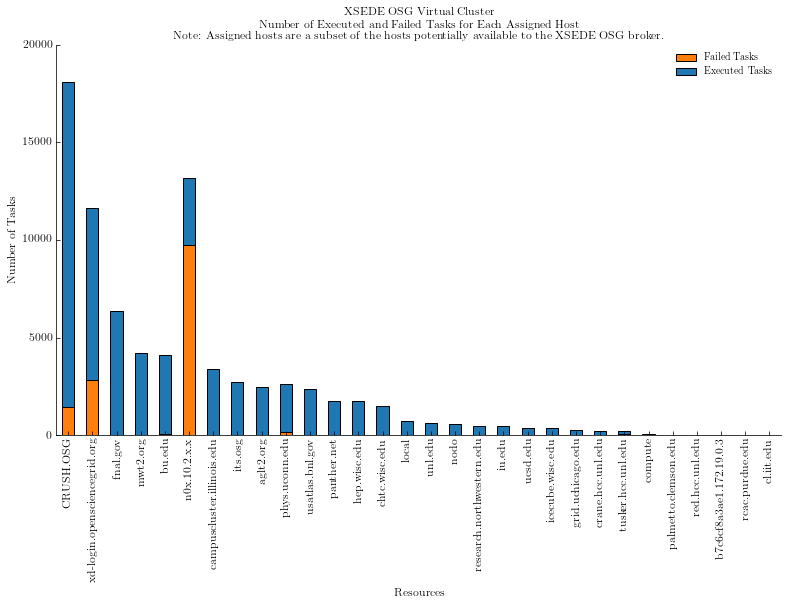

In [43]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of Executed and Failed Tasks for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

pippo = units

pd.concat(
    [pippo.loc[pippo['U_AGENT_EXECUTING'].isnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Failed Tasks'}),
     pippo.loc[pippo['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Executed Tasks'})], 
    axis=1).sort_values(
        by=['Executed Tasks','Failed Tasks'], 
        ascending=False).plot.bar(
            ax=ax, 
            stacked=True, 
            color=[tableau20[2],tableau20[0]], 
            title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')

plt.savefig('figures/osg_nunits_executed_failed_per_host.pdf', dpi=600, bbox_inches='tight')

In [44]:
us = units

top10hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:10].index.tolist()
top08hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:8].index.tolist()
tophost = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:1].index.tolist()

# display(us['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top10hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top08hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(tophost)]['U_AGENT_EXECUTING'].dropna().describe())

us[us['U_AGENT_EXECUTING'] <= 0.4]


,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,U_UMGR_BINDING,U_UMGR_SCHEDULING,experiment,hid,pid,sid,uid


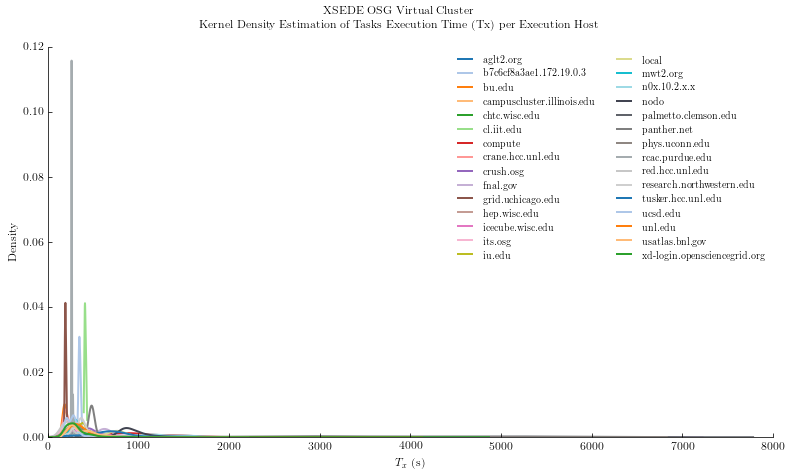

In [50]:
fig, ax = fig_setup()

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']

# mpl.rcParams['legend.frameon']  = False
# mpl.rcParams['patch.linewidth'] = 0.75
# mpl.rcParams['axes.linewidth']  = 0.75

# SIZE = 20
# plt.rc('font', size=SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
# plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=16)  # legend fontsize
# plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)  

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host'
fig.suptitle(title)

curves = {}
hosts = units['hid'].dropna().unique()

minni = units.loc[units['U_AGENT_EXECUTING'].notnull()]

for host in hosts:
    curves[host] = minni.loc[units['hid'] == host]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

curves = dict((k.lower(), v) for k,v in curves.iteritems())
    
utxh = pd.DataFrame(curves) 

utxh.plot.density(ax=ax, sort_columns=True, color=tableau20, linewidth=2)#, figsize=(15, 13), title=title) # subplots=True, layout=(4,4), sharey=True, sharex=True,
# plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.legend(ncol=2)
#ax.set_xlim((0, 2000))
ax.set_xlim((0))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

In [46]:
# s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist()
#s[0:1]

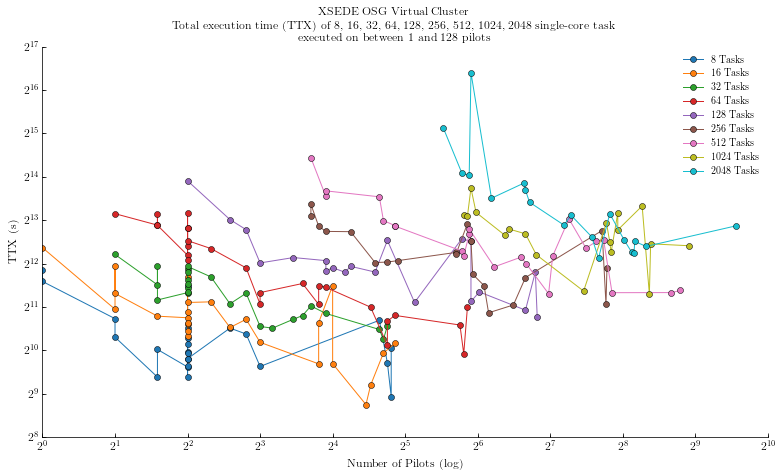

In [51]:
fig, ax = fig_setup()
fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 single-core task\nexecuted on between 1 and 128 pilots')

s = sessions.rename(columns={'npilot_active':'npilotactive'})

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1],
        tableau20[3], tableau20[5], tableau20[7], tableau20[9],
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    unts = s[s['nunit_requested']==u][['U_AGENT_EXECUTING', 'npilotactive']].dropna().sort_values('npilotactive').copy()
    ax.plot(unts.npilotactive, unts.U_AGENT_EXECUTING, marker='o', label='%s Tasks' % u, color=colors.pop(0))

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.legend(numpoints=1)
ax.set_xlabel('Number of Pilots (log)')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_active-pilots.pdf', dpi=600, bbox_inches='tight')

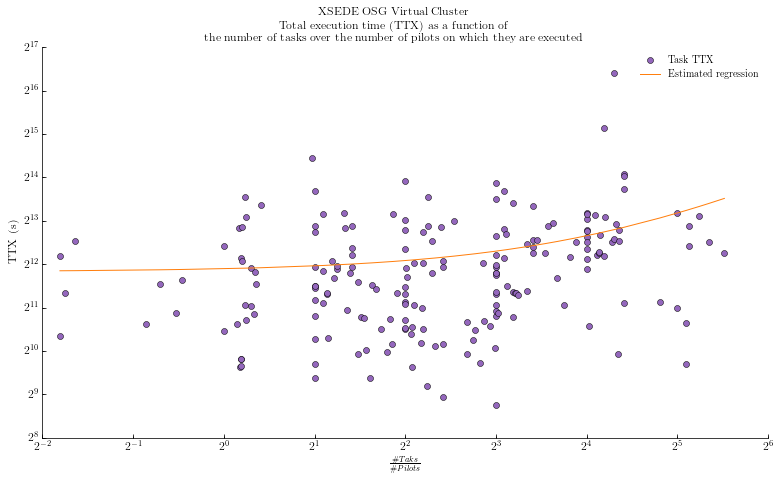

In [52]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

x = s['NuOnNpActive'].dropna().sort_values()
y = s['U_AGENT_EXECUTING'].dropna()
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)

ax.plot(x, y, marker='o', color=tableau20[8], linestyle='', label='Task TTX')
ax.plot(x, fit_fn(x), color=tableau20[2], label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots.pdf', dpi=600, bbox_inches='tight')

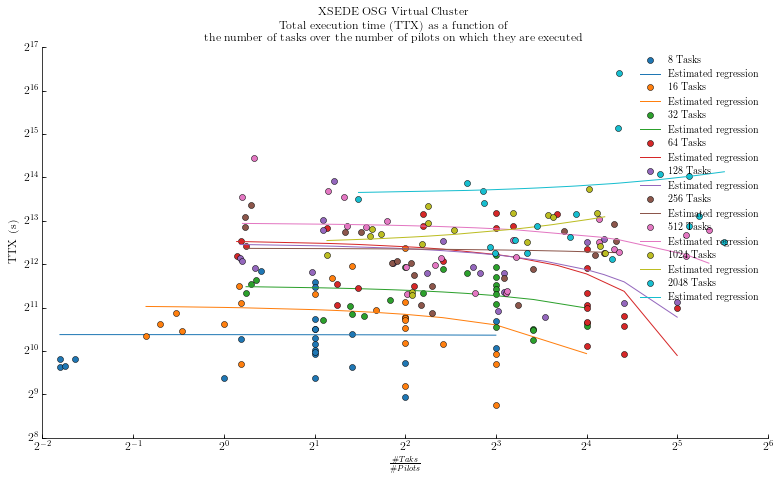

In [53]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    x = s[s['nunit_requested']==u]['NuOnNpActive'].dropna().sort_values().copy()
    y = s[s['nunit_requested']==u]['U_AGENT_EXECUTING'].dropna().copy()
    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit)
    c = colors.pop(0)

    ax.plot(x, y, marker='o', linestyle='', label='%s Tasks' % u, color=c)
    ax.plot(x, fit_fn(x), color=c, label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots_by_bot-size.pdf', dpi=600, bbox_inches='tight')

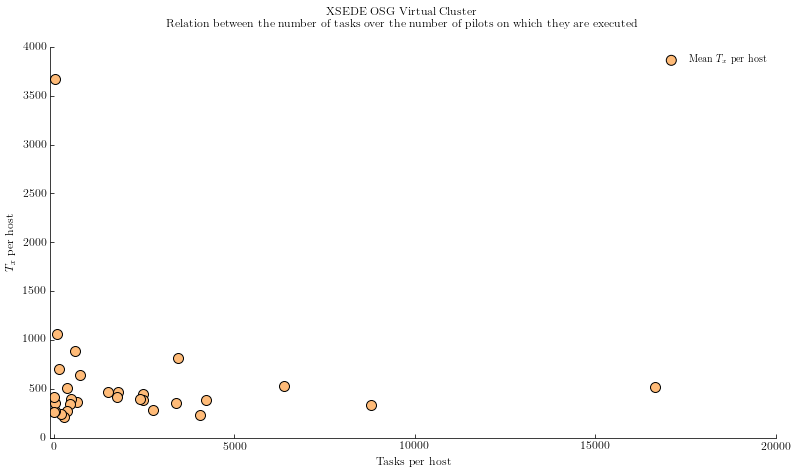

In [54]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Relation between '+\
'the number of tasks over the number of pilots on which they are executed'
fig.suptitle(title)

pluto = units
x = pluto.loc[pluto['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count()
y1 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').min().add_prefix('min_')
y2 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').mean().add_prefix('mean_')
y3 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').max().add_prefix('max_')
scatter = pd.concat([x, y1, y2, y3], axis=1).sort_values(by='uid', ascending=False)

# display(scatter)

# scatter.plot.scatter('uid', 'min_U_AGENT_EXECUTING', s=100, ax=ax, color=tableau20[1], lw=0.5)

# ax.scatter(scatter['uid'], scatter['min_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[1], label='Min $T_x$ per host')
ax.scatter(scatter['uid'], scatter['mean_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[3], label='Mean $T_x$ per host')
# ax.scatter(scatter['uid'], scatter['max_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[5], label='Max $T_x$ per host')

plt.xlabel('# Tasks per host')
plt.ylabel('$T_x$ per host')
ax.set_xlim((-100))
# ax.set_ylim((0, 6000))
ax.legend(scatterpoints=1)

plt.savefig('figures/osg_scatter_task-per-host_tx-per-host.pdf', dpi=600, bbox_inches='tight')

(0.98847926267281105, 32.0)

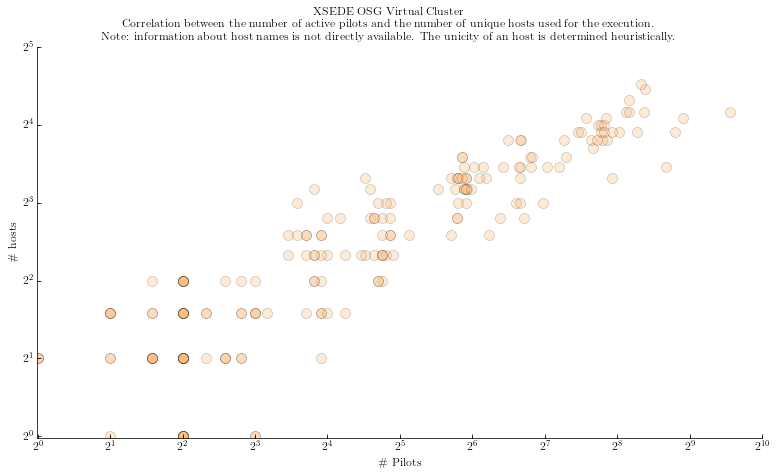

In [59]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of active pilots and the number of unique hosts used for the execution.\n'+\
'Note: information about host names is not directly available. The unicity of an host is determined heuristically.'
fig.suptitle(title)

paperino = sessions.copy()
ax.scatter(paperino['npilot_active'], paperino['nhost'], s=100, alpha=0.3, facecolor=tableau20[3], lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('\# Pilots')
plt.ylabel('\# hosts')
ax.set_xlim((-10))
ax.set_ylim((0))

# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

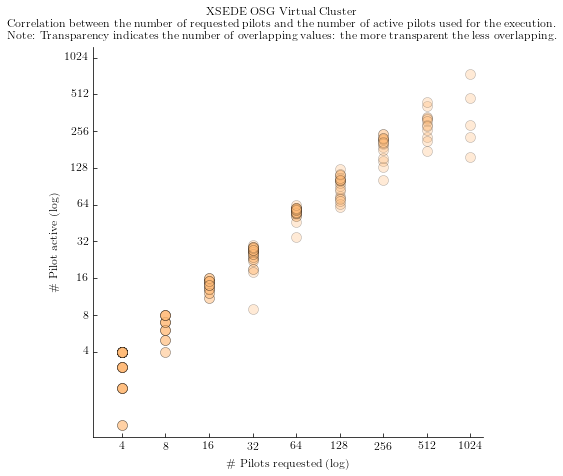

In [58]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested pilots and the number of active pilots used for the execution.\n'+\
'Note: Transparency indicates the number of overlapping values: the more transparent the less overlapping.'
fig.suptitle(title)

qui = sessions.rename(columns={'npilot_active':'NpActive'}).copy()
ax.scatter(qui['npilot'], qui['NpActive'], s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((10**0.4, 10**3.1))#-50, 550))
ax.set_ylim((10**-0.1, 10**3.1))

plt.minorticks_off()
plt.xticks([4,8,16,32,64,128,256,512,1024], [4,8,16,32,64,128,256,512,1024])
plt.yticks([4,8,16,32,64,128,256,512,1024], [4,8,16,32,64,128,256,512,1024])
plt.xlabel('\# Pilots requested (log)')
plt.ylabel('\# Pilot active (log)')

plt.savefig('figures/osg_scatter_npilots-requested_npilots-active.pdf', dpi=600, bbox_inches='tight')

In [27]:
pilots[(pilots['sid'] == 'rp.session.radical.mturilli.017134.0002') &
       (pilots['pid'] == 'pilot.0013')]['hid'].tolist()

['CRUSH.OSG']